# Train the Discriminator for Candidate Classification on the Sentence Level

This notebook is designed to train the following machine learning models: Long Short Term Memory Network (LSTM), [Doc2Vec](https://arxiv.org/pdf/1707.02377.pdf) with Logitstic Regression, and [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) with Logistic Regrssion. 

## MUST RUN AT THE START OF EVERYTHING

Set up the database for data extraction and load the Candidate subclass for the algorithms below

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import csv
import subprocess
import os

import numpy as np
import pandas as pd
import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import LabelAnnotator, load_marginals
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM
from snorkel.models import Candidate, FeatureKey, candidate_subclass

In [4]:
edge_type = "dg"

In [5]:
if edge_type == "dg":
    DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])
elif edge_type == "gg":
    GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])
elif edge_type == "cg":
    CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])
elif edge_type == "cd":
    CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])
else:
    print("Please pick a valid edge type")

# Load The Data

Here we load the sentences from the training and development set respectively. Both come from excel files that are on the repository as we speak.

In [6]:
train_sentences_df = pd.read_excel("data/sentence-labels_test.xlsx")
train_sentences_df.head(2)

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence,label,doid_name,gene_symbol,LF_HETNET_DISEASES,...,LF_IS_BIOMARKER,LF_ASSOCIATION,LF_NO_ASSOCIATION,LF_METHOD_DESC,LF_NO_CONCLUSION,LF_CONCLUSION,LF_DG_DISTANCE_SHORT,LF_DG_DISTANCE_LONG,LF_DG_ALLOWED_DISTANCE,LF_NO_VERB
0,21445,Presenile dementia,Pick,DOID:10652,9463,"Presenile dementia with Alzheimer-, Pick- and ...",0.433657,Alzheimer's disease,PICK1,0,...,0,0,0,0,-1,0,0,0,1,-1
1,21497,epilepsy,ACTH,DOID:1826,5443,EEG with intravenous diazepam is valuable for ...,0.972882,epilepsy syndrome,POMC,1,...,0,0,0,0,-1,0,0,0,1,0


In [7]:
dev_sentences_df = pd.read_excel("data/sentence-labels-dev.xlsx")
dev_sentences_df = dev_sentences_df[dev_sentences_df.curated_dsh.notnull()]
dev_sentences_df = dev_sentences_df.sort_values("candidate_id")
dev_sentences_df.head(2)

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence,label,doid_name,gene_symbol,LF_HETNET_DISEASES,...,LF_HETNET_ABSENT,LF_CHECK_GENE_TAG,LF_IS_BIOMARKER,LF_ASSOCIATION,LF_NO_ASSOCIATION,LF_NO_CONCLUSION,LF_DG_DISTANCE,LF_NO_VERB,curated_dsh,notes_dsh
74,228511,AML,TNF alpha,DOID:2531,7124,"However, addition of anti-TNF alpha (every 72 ...",0.286983,hematologic cancer,TNF,1,...,0,0,0,1,0,0,0,0,1.0,NaN
18,235489,non-Hodgkin's lymphomas,c-myc,DOID:0060073,4609,Steady state c-myc mRNA levels determined by N...,0.700525,lymphatic system cancer,MYC,0,...,-1,0,0,0,0,-1,0,0,0.0,NaN


# Doc2VecC

This block of code runs the doc2vec model, which is a model that converts sentences into a single dense vector. These vectors can be used in a popular machine learning model like logistic regression. The code below sets up the data for the doc2vec algorithm to run.

### Generate Data to be Embedded

In [ ]:
train_candidate_ids = train_sentences_df.candidate_id.astype(int).tolist()
dev_candidate_ids = (
    dev_sentences_df[dev_sentences_df.curated_dsh.notnull()]
    .candidate_id
    .astype(int)
    .tolist()
)

In [ ]:
train_cands = (
    session
    .query(Candidate)
    .filter(Candidate.id.in_(train_candidate_ids))
    .all() 
)

dev_cands = (
    session
    .query(Candidate)
    .filter(Candidate.id.in_(dev_candidate_ids))
    .all() 
)

In [ ]:
with open("data/doc2vec/train_data.txt", "w") as f:
    for c in tqdm.tqdm(train_cands):
        f.write(c.get_parent().text + "\n")

with open("data/doc2vec/dev_data_labeled.txt", "w") as f:
    for c in tqdm.tqdm(dev_cands):
        f.write(c.get_parent().text + "\n")

In [ ]:
dev_df = pd.read_excel("data/sentence-labels-dev.xlsx")
dev_df = dev_df[dev_df.curated_dsh.isnull()]
dev_df.head(2)

In [ ]:
target_ids = dev_df.candidate_id.astype(int).tolist()

In [ ]:
with open("data/doc2vec/dev_data_non_labeled.txt", "w") as f:
    for c in tqdm.tqdm(session.query(Candidate).filter(Candidate.id.in_(target_ids)).all()):
        f.write(c.get_parent().text + "\n")

### Generate Data to Train On

In [ ]:
sql = '''
SELECT * from candidate
WHERE split = 0 and type='disease_gene'
ORDER BY RANDOM()
LIMIT 500000;
'''
target_cids = [x[0] for x in session.execute(sql)]

In [ ]:
offset = 0
with open("data/doc2vec/train_data_500k.txt", "w") as f:
    while True:
        cands = session.query(Candidate).filter(Candidate.id.in_(target_cids)).offset(offset).limit(50000).all()
        
        if len(cands) == 0:
            break
            
        for c in tqdm.tqdm(cands):
            f.write(c.get_parent().text + "\n")
        
        offset += 50000

### Run Doc2Vec

When runnning doc2vec, make sure the first cell has finished running before starting the second. Subprocess creates a new process so both programs would be running simultaneously. As a result everything will slow down significantly. The submodule might not be compiled. If that is the case run this command: 
```bash
gcc doc2vecc.c -o doc2vecc -lm -pthread -O3 -march=native -funroll-loops
```

In [ ]:
command = [
    '../iclr2017/doc2vecc',
    '-train', 'data/doc2vec/train_data_500k.txt',
    '-output', 'data/doc2vec/doc_vectors/train_doc_vectors_500k.txt',
    '-cbow', '1',
    '-size', '500',
    '-negative', '5',
    '-hs', '0',
    '-threads', '5',
    '-binary', '0',
    '-iter', '30',
    '-test', 'data/doc2vec/train_data.txt',
    '-save-vocab', 'data/doc2vec/train_data_vocab_500k.txt'
]
subprocess.Popen(command)

In [ ]:
command = [
    '../iclr2017/doc2vecc',
    '-train', 'data/doc2vec/train_data_500k.txt',
    '-output', 'data/doc2vec/doc_vectors/dev_doc_vectors_non_labeled_500k.txt',
    '-cbow', '1',
    '-size', '500',
    '-negative', '5',
    '-hs', '0',
    '-threads', '5',
    '-binary', '0',
    '-iter', '30',
    '-test', 'data/doc2vec/dev_data_non_labeled.txt',
    '-read-vocab', 'data/doc2vec/train_data_vocab_500k.txt'
]
subprocess.Popen(command)

# Train Sparse Logistic Regression Disc Model

Here we train an SLR. To find the optimal hyperparameter settings this code uses a [random search](http://scikit-learn.org/stable/modules/grid_search.html) instead of iterating over all possible combinations of parameters. After the final model has been found, it is saved in the checkpoints folder to be loaded in the [next notebook](5.data-analysis.ipynb). Furthermore, the weights for the final model are output into a text file to be analyzed as well.

In [8]:
doc2vec_X = np.loadtxt("data/doc2vec/doc_vectors/train_doc_vectors.txt")
doc2vec_X = doc2vec_X[:-1, :]
doc2vec_dev_X = np.loadtxt("data/doc2vec/doc_vectors/dev_doc_vectors.txt")
doc2vec_dev_X = doc2vec_dev_X[:-1, :]

In [9]:
doc2vec_X_500k = np.loadtxt("data/doc2vec/doc_vectors/train_doc_vectors_500k.txt")
doc2vec_X_500k = doc2vec_X_500k[:-1,:]
doc2vec_dev_X_500k = np.loadtxt("data/doc2vec/doc_vectors/dev_doc_vectors_500k.txt")
doc2vec_dev_X_500k = doc2vec_dev_X_500k[:-1, :]

In [10]:
doc2vec_X_all = np.loadtxt("data/doc2vec/doc_vectors/train_doc_vectors_all.txt")
doc2vec_X_all= doc2vec_X_all[:-1,:]
doc2vec_dev_X_all = np.loadtxt("data/doc2vec/doc_vectors/dev_doc_vectors_all.txt")
doc2vec_dev_X_all = doc2vec_dev_X_all[:-1, :]

In [11]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(
    train_sentences_df.sentence.values
)
dev_X = vectorizer.transform(dev_sentences_df.sentence.values)

In [12]:
data = [
    X,
    doc2vec_X,
    doc2vec_X_500k,
    doc2vec_X_all
]

labels = [
    train_sentences_df.label.apply(lambda x: 1 if x > 0.5 else 0)
    for i in range(len(data))
]

model_labels = [
    "Bag-Of-Words",
    "Doc2Vec 50k",
    "Doc2Vec 500k",
    "Doc2Vec All"
]
    
lr_grids = [
    {'C':np.linspace(1,100, num=4)}
    for i in range(len(data))
]

final_models = []

In [13]:
lr_model = LogisticRegression()

In [14]:
%%time
for train_data, grid, y_labels in zip(data, lr_grids, labels):
    fit_model = GridSearchCV(lr_model, 
                         grid, cv=10, n_jobs=3, 
                         verbose=1, scoring='roc_auc', return_train_score=True)
    fit_model.fit(train_data, y_labels)
    final_models.append(fit_model)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:  4.8min finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed: 16.1min finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:  1.8min finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:  1.7min finished


CPU times: user 2min 17s, sys: 9.94 s, total: 2min 27s
Wall time: 26min 1s


Text(0.5,1,'BOW Training CV (10-fold)')

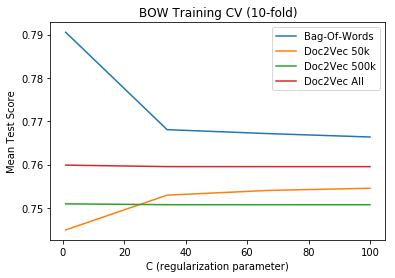

In [15]:
import matplotlib.pyplot as plt
for model, model_label in zip(final_models, model_labels):
    lr_result = pd.DataFrame(model.cv_results_)
    plt.plot(lr_result["param_C"], lr_result["mean_test_score"], label=model_label)
plt.legend()
plt.xlabel("C (regularization parameter)")
plt.ylabel("Mean Test Score")
plt.title("BOW Training CV (10-fold)")

In [16]:
lr_marginals = []
for model, test_data in zip(final_models, [dev_X, doc2vec_dev_X, doc2vec_dev_X_500k, doc2vec_dev_X_all]):
    lr_marginals.append(model.best_estimator_.predict_proba(test_data)[:,1])

In [17]:
marginals_df = (
    pd.DataFrame(lr_marginals)
    .transpose()
    .rename(index=str, columns={0:'Bag of Words', 1: 'Doc2Vec 50k', 2:'Doc2Vec 500k', 3:'Doc2Vec All'})
)
marginals_df.head(2)

,Bag of Words,Doc2Vec 50k,Doc2Vec 500k,Doc2Vec All
0,0.999456,0.448155,0.734870,0.697125
1,0.468116,0.999691,0.398248,0.549201


In [18]:
marginals_df.to_csv('data/disc_model_marginals.tsv', index=False, sep='\t')

## Save Best Model

In [19]:
pickle.dump(final_models[2], open("data/best_model.sav", "wb"))

## Get Top 100 and Bottom 100

In [ ]:
data_file="data/doc2vec/doc_vectors/dev_doc_vectors_non_labeled_500k.txt.xz"
doc2vec_dev_X_500k_unlabeled = pd.read_table(data_file, sep=" ", header=None)
doc2vec_dev_X_500k_unlabeled = (
    doc2vec_dev_X_500k_unlabeled
    .head(doc2vec_dev_X_500k_unlabeled.shape[0]-1)
    .drop(doc2vec_dev_X_500k_unlabeled.shape[1]-1, axis='columns')
    .values
)

In [ ]:
with open("data/doc2vec/dev_data_non_labled.txt", "r") as f:
    data = [line.strip() for line in f]

In [ ]:
dev_sentences_non_labeled_df = pd.read_excel("data/sentence-labels-dev.xlsx")
dev_sentences_non_labeled_df = dev_sentences_non_labeled_df.query("curated_dsh.isnull()")
dev_sentences_non_labeled_df.head(2)

In [ ]:
unlabeled_df = pd.DataFrame(
    list(zip(data, final_models[2].predict_proba(doc2vec_dev_X_500k_unlabeled)[:,1])),
    columns=['sentence','marginals'])
unlabeled_df.head(2)

In [ ]:
unlabeled_df = unlabeled_df.merge(dev_sentences_non_labeled_df, on="sentence")

In [ ]:
writer = pd.ExcelWriter('data/100_sentences_list_A.xlsx')
(unlabeled_df
     .sort_values("marginals", ascending=False)
     .head(100)[["disease", "gene", "sentence"]]
     .to_excel(writer, sheet_name='sentences', index=False)
)
if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)
writer.close()

In [ ]:
writer = pd.ExcelWriter('data/100_sentences_list_B.xlsx')
(unlabeled_df
     .sort_values("marginals", ascending=True)
     .head(100)[["disease", "gene", "sentence"]]
     .to_excel(writer, sheet_name='sentences', index=False)
)
if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)
writer.close()

## Use Best Model to Classify All Sentences

In [ ]:
train_X = pd.read_table("data/doc2vec/full_train_doc_vectors.txt", sep=" ", header=None)
train_X = train_X.head(train_X.shape[0]-1).drop(train_X.shape[1]-1, axis='columns').values

dev_X = pd.read_table("data/doc2vec/full_dev_doc_vectors.txt", sep=" ", header=None)
dev_X = dev_X.head(dev_X.shape[0]-1).drop(dev_X.shape[1]-1, axis='columns').values

In [ ]:
train_dg_map_df = pd.read_table("data/doc2vec/full_train_dg_map.txt", names=["disease_id", "gene_id"])
train_dg_map_df.head(2)

In [ ]:
dev_dg_map_df = pd.read_table("data/doc2vec/full_dev_dg_map.txt", names=["disease_id", "gene_id"])
dev_dg_map_df.head(2)

In [ ]:
best_model = final_models[2].best_estimator_
train_dg_map_df['marginals'] = best_model.predict_proba(train_X)[:,1]
train_dg_map_df.head(2)

In [ ]:
best_model = pickle.load(open("data/best_model.sav", "rb"))
dev_dg_map_df['marginals'] = best_model.predict_proba(dev_X)[:,1]
dev_dg_map_df.head(2)

In [ ]:
train_dg_map_df.to_csv("data/training_set_marginals.tsv", sep="\t", index=False)
dev_dg_map_df.to_csv("data/dev_set_marginals.tsv", sep="\t", index=False)